This scripts builds an Autoregressive Integrated Moving Average (ARIMA) model to perform anomaly detection. The script reads in a CSV file and outputs a plot that illustrates that anomalies that were detected based on the threshold defined. This script should be run after confirming that the data you are using is stationary. 

The source of the code is from the following website, although they are working with an ARMA model: https://www.analyticsvidhya.com/blog/2021/08/univariate-time-series-anomaly-detection-using-arima-model/ 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from joblib import Parallel, delayed


In [3]:
cpu_util_df = pd.read_csv("/Users/christinetsai/Desktop/ds4002/02-time-series-project/ds4002-project2/DATA/ec2_cpu_utilization_53ea38.csv")
cpu_util_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB


In [4]:
# make sure timestamp col is datetime type
cpu_util_df["timestamp"]=pd.to_datetime(cpu_util_df["timestamp"])

In [ ]:
# max values for p, d, and q
max_p, max_d, max_q = 5, 2, 5

def get_order_sets(n, n_per_set) -> list:
    n_sets = [i for i in range(n)]
    order_sets = [
        n_sets[i:i + n_per_set]
        for i in range(0, n, n_per_set)
    ]
    return order_sets

def find_aic_for_model(data, p, d, q, model, model_name):
    try:
        msg = f"Fitting {model_name} with order (p, d, q) = ({p}, {d}, {q})"
        print(msg)
        
        # avoid refitting if p=0, d=0, and q=1
        if (p, d, q) == (0, 0, 1):
            return None, (p, d, q)
        
        # fit ARIMA model
        ts_results = model(data, order=(p, d, q)).fit()
        curr_aic = ts_results.aic
        return curr_aic, (p, d, q)
    
    except Exception as e:
        print(f"Exception occurred for (p, d, q) = ({p}, {d}, {q}): {e}")
        return None, (p, d, q)

def find_best_order_for_model(data, model, model_name):
    p_ar, d_diff, q_ma = max_p, max_d, max_q
    final_results = []

    # initial fit with ARIMA(0, 1, 0)
    ts_results = model(data, order=(0, 1, 0)).fit()
    min_aic = ts_results.aic
    final_results.append((min_aic, (0, 1, 0)))
    
    # create order sets for q values
    order_sets = get_order_sets(q_ma + 1, 5)  

    for p in range(0, p_ar + 1):
        for d in range(0, d_diff + 1):
            for order_set in order_sets:
                # fit the model and find AIC in parallel for different q values
                results = Parallel(n_jobs=len(order_set), prefer='threads')(
                    delayed(find_aic_for_model)(data, p, d, q, model, model_name)
                    for q in order_set
                )
                final_results.extend(results)
    
    # create a dataframe with results
    results_df = pd.DataFrame(
        [res for res in final_results if res[0] is not None],
        columns=['aic', 'order']
    )

    # find the order with the minimum AIC
    min_df = results_df[results_df['aic'] == results_df['aic'].min()]
    min_aic = min_df['aic'].iloc[0]
    min_order = min_df['order'].iloc[0]
    
    return min_aic, min_order, results_df


In [ ]:
# print the best p, d, and q parameters to use for the model 
min_aic, min_order, results_df = find_best_order_for_model(cpu_util_df["value"], ARIMA, "ARIMA")

print("MIN_AIC: ", min_aic, "MIN_ORDER: ", min_order)

In [5]:
''' build arima model
ARIMA's parameters: p, d, and q
p = for autoregression pt of model; how far back in time should we go to predict the current observation
d = order of differencing
q = for moving avg part of the model; represents num of lagged forecast errors included in the model 
'''
model_arima=ARIMA(cpu_util_df['value'],order=(5, 0, 5)) # using (5, 0, 5) as order based on running helper functions above that find this order for us
model_arima=model_arima.fit()



/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# returns in-sample predictions for the training period
forecast_values = model_arima.fittedvalues.reset_index(drop=True)
forecast_values.head()

0    1.831289
1    1.841305
2    1.863596
3    1.826288
4    1.822511
dtype: float64

In [ ]:
# get the in-sample predictions (fitted values) to calculate confidence bounds
fitted_values = model_arima.fittedvalues.reset_index(drop=True)

# calculate residuals (actual - predicted) to compute std
residuals = cpu_util_df["value"] - fitted_values
std_resid = np.std(residuals)

# define bounds using residual standard deviation
# z_score = 2.576 associated w/ 99% confidence, but i had to adjust the z_score to address the increase in false positives 
z_score = 3.5
upper_bound = fitted_values + (z_score * std_resid)
lower_bound = fitted_values - (z_score * std_resid)

In [ ]:
# add columns to dataframe for the lower and upper bounds for an observation, as well as whether an observation is an anomaly
cpu_util_df["lower_bound"] = lower_bound
cpu_util_df["upper_bound"] = upper_bound
cpu_util_df["is_anomaly"] = (
    (cpu_util_df["value"] > upper_bound)
).astype(int)
cpu_util_df.head(100)

,timestamp,value,lower_bound,upper_bound,is_anomaly
0,2014-02-14 14:30:00,1.732,1.575823,2.086755,0
1,2014-02-14 14:35:00,1.732,1.585838,2.096771,0
2,2014-02-14 14:40:00,1.960,1.608129,2.119062,0
3,2014-02-14 14:45:00,1.732,1.570822,2.081754,0
4,2014-02-14 14:50:00,1.706,1.567045,2.077977,0
...,...,...,...,...,...
95,2014-02-14 22:25:00,1.838,1.528621,2.039554,0
96,2014-02-14 22:30:00,1.966,1.556618,2.067551,0
97,2014-02-14 22:35:00,1.932,1.553993,2.064926,0
98,2014-02-14 22:40:00,2.162,1.650282,2.161214,1


In [9]:
# sum up number of anomalies
cpu_util_df["is_anomaly"].sum()

29

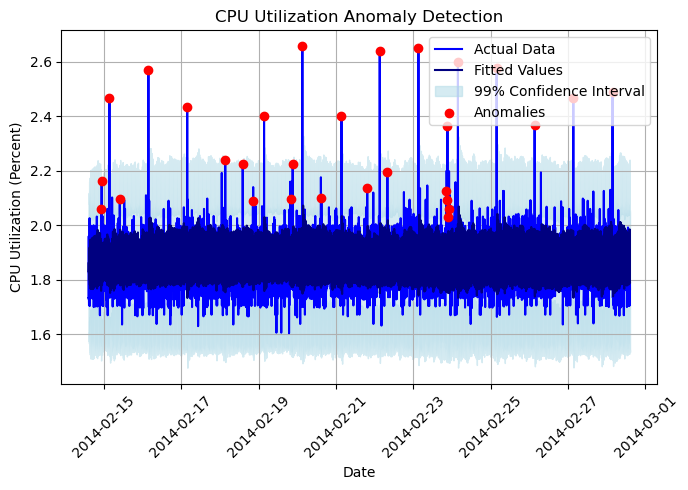

In [ ]:
# plot the forecasted values with the confidence intervals
from matplotlib.dates import DateFormatter, DayLocator
import matplotlib.dates as mdates


plt.figure(figsize=(7, 5))
plt.plot(cpu_util_df['timestamp'], cpu_util_df['value'], label="Actual Data", color='blue')
plt.plot(cpu_util_df['timestamp'], fitted_values, label="Fitted Values", color='navy')
plt.fill_between(cpu_util_df['timestamp'], lower_bound, upper_bound, color='lightblue', alpha=0.5, label="99% Confidence Interval")
anomalies = cpu_util_df[cpu_util_df["is_anomaly"] == 1]
plt.scatter(
    anomalies['timestamp'],
    anomalies['value'],
    color='red',
    label="Anomalies",
    zorder=5,
)
plt.xlabel("Date")
plt.ylabel("CPU Utilization (Percent)")
plt.title("CPU Utilization Anomaly Detection")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

This is the end of the script, but note that it only walks through building the ARIMA model for 1 of the 3 types of server metric logs. Repeat this process for the rest of the server metric logs you have not worked with yet. 